In [1]:
#Importing Libraries:

import findspark
import os
import sys
os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable

In [2]:
#Initializing findspark:
findspark.init()

In [3]:
#Importing pyspark libraries:

import pyspark
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import *

In [4]:
#Connection between spark and Mongo DB 

spark = SparkSession.builder.appName("myApp").config("spark.mongodb.input.uri","mongodb://localhost:27017/Rest.Rest?readPreference=primaryPreferred").config("spark.mongodb.output.uri","mongodb://localhost:27017/Rest.Rest").config("spark.jars.packages","org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").getOrCreate()

In [6]:
#Fetching the data from url and creating spark context

url="https://raw.githubusercontent.com/gayatripandit006/CDAC--DBDA-Project/main/Restaurant_Reviews_Raw.txt"
from pyspark import SparkFiles
spark.sparkContext.addFile(url)
SparkFiles.get("Restaurant_Review_Raw.txt")



'C:\\Users\\jarvi\\AppData\\Local\\Temp\\spark-c716ab45-69d3-4776-80e8-30853a222da0\\userFiles-cc531961-24c7-4b12-804e-ed3be2c27d9b\\Restaurant_Review_Raw.txt'

In [7]:
#Reading the file through spark:

raw_dataset=spark.read.option("delimiter", "\t").csv("Restaurant_Review_Raw.txt",header=True)

In [8]:
#Dataframe 1:
raw_dataset.show()

+---------------+--------------------+--------------------+------+--------------------+--------------------+--------+
|     Restaurant|            Reviewer|              Review|Rating|            Metadata|                Time|Pictures|
+---------------+--------------------+--------------------+------+--------------------+--------------------+--------+
|Beyond Flavours|   Rusha Chakraborty|The ambience was ...|     5|1 Review . 2 Foll...|5/25/2019  3:54:0...|       0|
|Beyond Flavours|Anusha Tirumalaneedi|Ambience is too g...|     5|3 Reviews . 2 Fol...|5/25/2019  2:20:0...|       0|
|Beyond Flavours|     Ashok Shekhawat|A must try.. grea...|     5|2 Reviews . 3 Fol...|5/24/2019  10:54:...|       0|
|Beyond Flavours|      Swapnil Sarkar|Soumen das and Ar...|     5|1 Review . 1 Foll...|5/24/2019  10:11:...|       0|
|Beyond Flavours|              Dileep|Food is good.we o...|     5|3 Reviews . 2 Fol...|5/24/2019  9:37:0...|       0|
|Beyond Flavours|       Nagabhavani K|Ambiance is good..

In [9]:
#Count of rows in original dataset:

raw_dataset.count()

10001

In [ ]:
#Exporting raw data to MongoDB
raw_dump = spark.read.format("mongo").option("uri","mongodb://localhost:27017/Rest.Raw_data").load()
raw_dataset.write.format("mongo").option("uri","mongodb://localhost:27017/Rest.raw_data").save()

In [11]:
#Splitting the data into two subsets:
#Dataframe 1: ['Restaurant', 'Review']
raw_dataset.drop("Reviewer","Rating","MetaData","Time","Pictures") \
    .printSchema()

cols = ("Reviewer","Rating","MetaData","Time","Pictures")

#New Dataframe 1:
df1 = raw_dataset.drop(*cols)


root
 |-- Restaurant: string (nullable = true)
 |-- Review: string (nullable = true)



In [12]:
#Check Null Values if exist any: (Before dropping)

checkNullValues = {col:df1.filter(df1[col].isNull()).count() for col in df1.columns}
print(checkNullValues)

{'Restaurant': 0, 'Review': 45}


In [13]:
#Filtering out null values:

df1.filter(col("Review").isNull()).show()

+-------------------+------+
|         Restaurant|Review|
+-------------------+------+
|               Amul|  null|
|       Being Hungry|  null|
|    Hyderabad Chefs|  null|
|    Hyderabad Chefs|  null|
|       Olive Garden|  null|
| Al Saba Restaurant|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
|American Wild Wings|  null|
+-------------------+------+
only showing top 20 rows



In [14]:
### Drop rows with Null values with where condition:
 
drop_1 = df1.where(col('Review').isNotNull())
drop_1.show()

+---------------+--------------------+
|     Restaurant|              Review|
+---------------+--------------------+
|Beyond Flavours|The ambience was ...|
|Beyond Flavours|Ambience is too g...|
|Beyond Flavours|A must try.. grea...|
|Beyond Flavours|Soumen das and Ar...|
|Beyond Flavours|Food is good.we o...|
|Beyond Flavours|Ambiance is good....|
|Beyond Flavours|Its a very nice p...|
|Beyond Flavours|Well after readin...|
|Beyond Flavours|Excellent food . ...|
|Beyond Flavours|Came for the birt...|
|Beyond Flavours|The service was g...|
|Beyond Flavours|Very good ambienc...|
|Beyond Flavours|Food was very goo...|
|Beyond Flavours|Food is too good....|
|Beyond Flavours|We ordered corn c...|
|Beyond Flavours|Food and ambience...|
|Beyond Flavours|Came here for lun...|
|Beyond Flavours|The best thing ab...|
|Beyond Flavours|Polite and friend...|
|Beyond Flavours|Food is really go...|
+---------------+--------------------+
only showing top 20 rows



In [15]:
#Check Null Values if exist any: (After dropping)

checkNullValues = {col:drop_1.filter(drop_1[col].isNull()).count() for col in drop_1.columns}
print(checkNullValues)

{'Restaurant': 0, 'Review': 0}


In [16]:
drop_1.count()

9956

In [17]:
# Remove leading and trailing spaces in columns:
from pyspark.sql.functions import trim
drop_1.withColumn("Restaurant",trim(col("Restaurant"))).show(5, truncate = False)


+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Restaurant     |Review                                                                                                                                                                                       |
+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Beyond Flavours|The ambience was good. food was quite good . had Saturday lunch . which was cost effective .                                                                                                 |
|Beyond Flavours|Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kudos to the service       

In [18]:
#Distinct Count of Restaurant Column:

from pyspark.sql.functions import countDistinct
distinct_count=drop_1.select(countDistinct("Restaurant"))
distinct_count.show()

+--------------------------+
|count(DISTINCT Restaurant)|
+--------------------------+
|                       101|
+--------------------------+



In [19]:
#Importing required library for String Indexing:

from pyspark.ml.feature import StringIndexer

In [20]:
#Apply String Indexer to Column Restuarant:

restaurant_indexer  = StringIndexer(inputCol = "Restaurant",outputCol = "Index")

#Fits a model to input dataset with optional parameters.
index_1 = restaurant_indexer.fit(drop_1).transform(drop_1)
index_1.show(5, truncate = False)

+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Restaurant     |Review                                                                                                                                                                                       |Index|
+---------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|Beyond Flavours|The ambience was good. food was quite good . had Saturday lunch . which was cost effective .                                                                                                 |11.0 |
|Beyond Flavours|Ambience is too good for a pleasant evening. Service is very prompt. Food is good. Over all a good experience. Soumen Das - kud

In [21]:
sort_1 = index_1.select("Index","Restaurant","Review")
sort_1.show()

+-----+---------------+--------------------+
|Index|     Restaurant|              Review|
+-----+---------------+--------------------+
| 11.0|Beyond Flavours|The ambience was ...|
| 11.0|Beyond Flavours|Ambience is too g...|
| 11.0|Beyond Flavours|A must try.. grea...|
| 11.0|Beyond Flavours|Soumen das and Ar...|
| 11.0|Beyond Flavours|Food is good.we o...|
| 11.0|Beyond Flavours|Ambiance is good....|
| 11.0|Beyond Flavours|Its a very nice p...|
| 11.0|Beyond Flavours|Well after readin...|
| 11.0|Beyond Flavours|Excellent food . ...|
| 11.0|Beyond Flavours|Came for the birt...|
| 11.0|Beyond Flavours|The service was g...|
| 11.0|Beyond Flavours|Very good ambienc...|
| 11.0|Beyond Flavours|Food was very goo...|
| 11.0|Beyond Flavours|Food is too good....|
| 11.0|Beyond Flavours|We ordered corn c...|
| 11.0|Beyond Flavours|Food and ambience...|
| 11.0|Beyond Flavours|Came here for lun...|
| 11.0|Beyond Flavours|The best thing ab...|
| 11.0|Beyond Flavours|Polite and friend...|
| 11.0|Bey

In [26]:
dump1 = spark.read.format("mongo").option("uri","mongodb://localhost:27017/Rest.dataset_1").load()
sort_1.write.format("mongo").option("uri","mongodb://localhost:27017/Rest.dataset_1").save()

In [22]:
#Dataframe 2: ['Restaurant', 'Reviewer', 'Rating']
raw_dataset.drop("Review","MetaData","Time","Pictures") \
    .printSchema()

cols = ("Review","MetaData","Time","Pictures")

#New Dataframe 2:
df2 = raw_dataset.drop(*cols)

root
 |-- Restaurant: string (nullable = true)
 |-- Reviewer: string (nullable = true)
 |-- Rating: string (nullable = true)



In [23]:
#Check Null Values if exist any: (Before dropping)

checkNullValues = {col:df2.filter(df2[col].isNull()).count() for col in df2.columns}
print(checkNullValues)

{'Restaurant': 0, 'Reviewer': 38, 'Rating': 39}


In [24]:
### Drop rows with Null values with where condition:

df3= df2.where(col('Rating').isNotNull())
df3.show()


+---------------+--------------------+------+
|     Restaurant|            Reviewer|Rating|
+---------------+--------------------+------+
|Beyond Flavours|   Rusha Chakraborty|     5|
|Beyond Flavours|Anusha Tirumalaneedi|     5|
|Beyond Flavours|     Ashok Shekhawat|     5|
|Beyond Flavours|      Swapnil Sarkar|     5|
|Beyond Flavours|              Dileep|     5|
|Beyond Flavours|       Nagabhavani K|     5|
|Beyond Flavours|     Jamuna Bhuwalka|     5|
|Beyond Flavours|           Sandhya S|     4|
|Beyond Flavours|        Akash Thorat|     5|
|Beyond Flavours|      Smarak Patnaik|     5|
|Beyond Flavours|    Saubhagya Bhuyan|     5|
|Beyond Flavours|          Srivaths07|     5|
|Beyond Flavours|         Kunj Mishra|     5|
|Beyond Flavours|   Pradeep Vetapalem|     5|
|Beyond Flavours|       Kankaria.ritu|     1|
|Beyond Flavours|        Abhay Sharma|     5|
|Beyond Flavours|     Shubham Jaiswal|     4|
|Beyond Flavours|   Srijani Mukherjee|     5|
|Beyond Flavours|         Hari Jan

In [25]:
#Check Null Values if exist any: (After dropping)

checkNullValues = {col:df3.filter(df3[col].isNull()).count() for col in df3.columns}
print(checkNullValues)


{'Restaurant': 0, 'Reviewer': 0, 'Rating': 0}


In [26]:
# Remove leading and trailing spaces in columns:
from pyspark.sql.functions import trim
df3.withColumn("Restaurant",trim(col("Restaurant"))).show(5, truncate = False)

+---------------+--------------------+------+
|Restaurant     |Reviewer            |Rating|
+---------------+--------------------+------+
|Beyond Flavours|Rusha Chakraborty   |5     |
|Beyond Flavours|Anusha Tirumalaneedi|5     |
|Beyond Flavours|Ashok Shekhawat     |5     |
|Beyond Flavours|Swapnil Sarkar      |5     |
|Beyond Flavours|Dileep              |5     |
+---------------+--------------------+------+
only showing top 5 rows



In [27]:
df3.count()

9962

In [28]:
#Distinct Count of Restaurant Column:

from pyspark.sql.functions import countDistinct, count
distinct_count=df3.select(countDistinct("Restaurant"))
distinct_count.show()

+--------------------------+
|count(DISTINCT Restaurant)|
+--------------------------+
|                       101|
+--------------------------+



In [29]:
#Distinct Count of Reviewer Column:

distinct_count=df3.select(countDistinct("Reviewer"))
distinct_count.show()

+------------------------+
|count(DISTINCT Reviewer)|
+------------------------+
|                    7447|
+------------------------+



In [30]:
#Distinct Count of Rating Column:

distinct_count=df3.select(countDistinct("Rating"))
distinct_count.show()

+----------------------+
|count(DISTINCT Rating)|
+----------------------+
|                    11|
+----------------------+



In [31]:
#Apply String Indexer to Column Restuarant:

restaurant_indexer  = StringIndexer(inputCol = "Restaurant",outputCol = "Restaurant_Index")

#Fits a model to input dataset with optional parameters.
restaurant_index = restaurant_indexer.fit(df3).transform(df3)
restaurant_index.show(5, truncate = False)

+---------------+--------------------+------+----------------+
|Restaurant     |Reviewer            |Rating|Restaurant_Index|
+---------------+--------------------+------+----------------+
|Beyond Flavours|Rusha Chakraborty   |5     |14.0            |
|Beyond Flavours|Anusha Tirumalaneedi|5     |14.0            |
|Beyond Flavours|Ashok Shekhawat     |5     |14.0            |
|Beyond Flavours|Swapnil Sarkar      |5     |14.0            |
|Beyond Flavours|Dileep              |5     |14.0            |
+---------------+--------------------+------+----------------+
only showing top 5 rows



In [32]:
#Apply String Indexer to Column Reviewer:

reviewer_indexer  = StringIndexer(inputCol = "Reviewer",outputCol = "Reviewer_Index")

#Fits a model to input dataset with optional parameters.
reviewer_index = reviewer_indexer.fit(df3).transform(df3)
reviewer_index.show(5, truncate = False)

+---------------+--------------------+------+--------------+
|Restaurant     |Reviewer            |Rating|Reviewer_Index|
+---------------+--------------------+------+--------------+
|Beyond Flavours|Rusha Chakraborty   |5     |5430.0        |
|Beyond Flavours|Anusha Tirumalaneedi|5     |1953.0        |
|Beyond Flavours|Ashok Shekhawat     |5     |2102.0        |
|Beyond Flavours|Swapnil Sarkar      |5     |6759.0        |
|Beyond Flavours|Dileep              |5     |354.0         |
+---------------+--------------------+------+--------------+
only showing top 5 rows



In [33]:
#Apply String Indexer to Column Rating:

rating_indexer  = StringIndexer(inputCol = "Rating",outputCol = "Rating_Index")

#Fits a model to input dataset with optional parameters.
rating_index = rating_indexer.fit(df3).transform(df3)
rating_index.show(5, truncate = False)

+---------------+--------------------+------+------------+
|Restaurant     |Reviewer            |Rating|Rating_Index|
+---------------+--------------------+------+------------+
|Beyond Flavours|Rusha Chakraborty   |5     |0.0         |
|Beyond Flavours|Anusha Tirumalaneedi|5     |0.0         |
|Beyond Flavours|Ashok Shekhawat     |5     |0.0         |
|Beyond Flavours|Swapnil Sarkar      |5     |0.0         |
|Beyond Flavours|Dileep              |5     |0.0         |
+---------------+--------------------+------+------------+
only showing top 5 rows



In [34]:
#Import libraries for creating pipeline:
from pyspark.ml import Pipeline

In [35]:
#Recreate the schema for Dataframe 2: ['Restaurant', 'Reviewer', 'Rating']
from pyspark.ml.feature import StringIndexer

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df3) for column in list(set(df3.columns))]


pipeline = Pipeline(stages=indexers)
final_df3= pipeline.fit(df3).transform(df3)

final_df3.show()

+---------------+--------------------+------+------------+----------------+--------------+
|     Restaurant|            Reviewer|Rating|Rating_index|Restaurant_index|Reviewer_index|
+---------------+--------------------+------+------------+----------------+--------------+
|Beyond Flavours|   Rusha Chakraborty|     5|         0.0|            14.0|        5430.0|
|Beyond Flavours|Anusha Tirumalaneedi|     5|         0.0|            14.0|        1953.0|
|Beyond Flavours|     Ashok Shekhawat|     5|         0.0|            14.0|        2102.0|
|Beyond Flavours|      Swapnil Sarkar|     5|         0.0|            14.0|        6759.0|
|Beyond Flavours|              Dileep|     5|         0.0|            14.0|         354.0|
|Beyond Flavours|       Nagabhavani K|     5|         0.0|            14.0|        4171.0|
|Beyond Flavours|     Jamuna Bhuwalka|     5|         0.0|            14.0|        3201.0|
|Beyond Flavours|           Sandhya S|     4|         1.0|            14.0|        5720.0|

In [36]:
type_conversion= final_df3.withColumn("Rating",final_df3.Rating.cast("Double")).printSchema()

root
 |-- Restaurant: string (nullable = true)
 |-- Reviewer: string (nullable = true)
 |-- Rating: double (nullable = true)
 |-- Rating_index: double (nullable = false)
 |-- Restaurant_index: double (nullable = false)
 |-- Reviewer_index: double (nullable = false)



In [42]:
dump2 = spark.read.format("mongo").option("uri","mongodb://localhost:27017/Rest.dataset_2").load()
final_df3.write.format("mongo").option("uri","mongodb://localhost:27017/Rest.dataset_2").save()

In [37]:
!pip install pymongo

In [38]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pymongo
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import plotly.express as px

In [39]:
client = MongoClient('localhost',27017)
db = client.Rest
data = db.dataset_1
df1 = pd.DataFrame(list(data.find()))
df1

,_id,Index,Restaurant,Review
0,63254b88fa714c70be06754c,11.0,Beyond Flavours,The ambience was good. food was quite good . h...
1,63254b88fa714c70be06754d,11.0,Beyond Flavours,Ambience is too good for a pleasant evening. S...
2,63254b88fa714c70be06754e,11.0,Beyond Flavours,A must try.. great food great ambience. Thnx f...
3,63254b88fa714c70be06754f,11.0,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...
4,63254b88fa714c70be067550,11.0,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...
...,...,...,...,...
9951,63254b88fa714c70be069c2b,15.0,Chinese Pavilion,Madhumathi Mahajan Well to start with nice cou...
9952,63254b88fa714c70be069c2c,15.0,Chinese Pavilion,This place has never disappointed us.. The foo...
9953,63254b88fa714c70be069c2d,15.0,Chinese Pavilion,"""Bad rating is mainly because of """"Chicken Bon..."
9954,63254b88fa714c70be069c2e,15.0,Chinese Pavilion,I personally love and prefer Chinese Food. Had...


In [40]:
# Remove column name '_id'
df1=df1.drop(['_id'], axis=1)


In [41]:
reviews = df1.copy()#making a copy of the df

In [42]:
reviews.head()

,Index,Restaurant,Review
0,11.0,Beyond Flavours,The ambience was good. food was quite good . h...
1,11.0,Beyond Flavours,Ambience is too good for a pleasant evening. S...
2,11.0,Beyond Flavours,A must try.. great food great ambience. Thnx f...
3,11.0,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...
4,11.0,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...


In [43]:
reviews.shape

(9956, 3)

In [44]:
reviews.columns

Index(['Index', 'Restaurant', 'Review'], dtype='object')

In [45]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9956 entries, 0 to 9955
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Index       9956 non-null   float64
 1   Restaurant  9956 non-null   object 
 2   Review      9956 non-null   object 
dtypes: float64(1), object(2)
memory usage: 233.5+ KB


In [46]:
reviews.isnull().sum() #counting null values for each column

Index         0
Restaurant    0
Review        0
dtype: int64

In [47]:
#importing NLP libraries
!pip install TextBlob
from textblob import TextBlob
import re
import nltk
from nltk.corpus import stopwords

In [48]:
import re
import nltk
from nltk.corpus import stopwords
corpus = []
for i in range(0,len(reviews["Review"])):
    print(i)
    review = re.sub('[^a-zA-Z]',' ', str(reviews["Review"][i]))
    review = review.lower() #Lowering the words is very imporatant in avoiding classifying same words as different words
    review = review.split()
    review = ' '.join(review) #Reconstructing sentences
    #print(review)
    corpus.append(review)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510
2511
2512
2513
2514
2515
2516
2517
2518
2519
2520
2521
2522
2523
2524
2525
2526
2527
2528
2529
2530
2531
2532
2533
2534
2535
2536
2537
2538
2539
2540
2541
2542
2543
2544
2545
2546
2547
2548
2549
2550
2551
2552
2553
2554
2555
2556
2557
2558
2559
2560
2561
2562
2563
2564
2565
2566
2567
2568
2569
2570
2571
2572
2573
2574
2575
2576
2577
2578
2579
2580
2581
2582
2583
2584
2585
2586
2587
2588
2589
2590
2591
2592
2593
2594
2595
2596
2597
2598
2599
2600
2601
2602
2603
2604
2605
2606
2607
2608
2609
2610
2611
2612
2613
2614
2615
2616
2617
2618
2619
2620
2621
2622
2623
2624
2625
2626
2627
2628
2629
2630
2631
2632
2633
2634
2635
2636
2637
2638
2639
2640
2641
2642
2643
2644


4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810
4811
4812
4813
4814
4815
4816
4817
4818
4819
4820
4821
4822
4823
4824
4825
4826
4827
4828
4829
4830
4831
4832
4833
4834
4835
4836
4837
4838
4839
4840
4841
4842
4843
4844
4845
4846
4847
4848
4849
4850
4851
4852
4853
4854


7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183
7184
7185
7186
7187
7188
7189
7190
7191
7192
7193
7194
7195
7196
7197
7198
7199
7200
7201
7202
7203
7204
7205
7206
7207
7208
7209
7210
7211
7212


9153
9154
9155
9156
9157
9158
9159
9160
9161
9162
9163
9164
9165
9166
9167
9168
9169
9170
9171
9172
9173
9174
9175
9176
9177
9178
9179
9180
9181
9182
9183
9184
9185
9186
9187
9188
9189
9190
9191
9192
9193
9194
9195
9196
9197
9198
9199
9200
9201
9202
9203
9204
9205
9206
9207
9208
9209
9210
9211
9212
9213
9214
9215
9216
9217
9218
9219
9220
9221
9222
9223
9224
9225
9226
9227
9228
9229
9230
9231
9232
9233
9234
9235
9236
9237
9238
9239
9240
9241
9242
9243
9244
9245
9246
9247
9248
9249
9250
9251
9252
9253
9254
9255
9256
9257
9258
9259
9260
9261
9262
9263
9264
9265
9266
9267
9268
9269
9270
9271
9272
9273
9274
9275
9276
9277
9278
9279
9280
9281
9282
9283
9284
9285
9286
9287
9288
9289
9290
9291
9292
9293
9294
9295
9296
9297
9298
9299
9300
9301
9302
9303
9304
9305
9306
9307
9308
9309
9310
9311
9312
9313
9314
9315
9316
9317
9318
9319
9320
9321
9322
9323
9324
9325
9326
9327
9328
9329
9330
9331
9332
9333
9334
9335
9336
9337
9338
9339
9340
9341
9342
9343
9344
9345
9346
9347
9348
9349
9350
9351
9352


In [49]:
from nltk.tokenize import word_tokenize

In [50]:
corpus

['the ambience was good food was quite good had saturday lunch which was cost effective',
 'ambience is too good for a pleasant evening service is very prompt food is good over all a good experience soumen das kudos to the service',
 'a must try great food great ambience thnx for the service by pradeep and subroto my personal recommendation is penne alfredo pasta also the music in the background is amazing',
 'soumen das and arun was a great guy only because of their behavior and sincerety and good food off course i would like to visit this place again',
 'food is good we ordered kodi drumsticks and basket mutton biryani all are good thanks to pradeep he served well we enjoyed here ambience is also very good',
 'ambiance is good service is good food is apradeecp and subro best service',
 'its a very nice place ambience is different all the food we ordered was very tasty service is also gud worth visit its reasonable as well really a must visit place',
 'well after reading so many revie

In [51]:
corpus_series = pd.Series(corpus,name="corpus_series")

In [52]:
reviews = pd.concat([reviews, corpus_series], axis=1)

In [53]:
reviews

,Index,Restaurant,Review,corpus_series
0,11.0,Beyond Flavours,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...
1,11.0,Beyond Flavours,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...
2,11.0,Beyond Flavours,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...
3,11.0,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...
4,11.0,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...
...,...,...,...,...
9951,15.0,Chinese Pavilion,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...
9952,15.0,Chinese Pavilion,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...
9953,15.0,Chinese Pavilion,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...
9954,15.0,Chinese Pavilion,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...


In [54]:

import nltk
#nltk.download('stopwords')

In [55]:
stop = stopwords.words('english')

In [56]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [57]:
reviews['corpus_series_without_stopwords'] = reviews["corpus_series"].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [58]:
reviews

,Index,Restaurant,Review,corpus_series,corpus_series_without_stopwords
0,11.0,Beyond Flavours,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...,ambience good food quite good saturday lunch c...
1,11.0,Beyond Flavours,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...,ambience good pleasant evening service prompt ...
2,11.0,Beyond Flavours,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...,must try great food great ambience thnx servic...
3,11.0,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...,soumen das arun great guy behavior sincerety g...
4,11.0,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...,food good ordered kodi drumsticks basket mutto...
...,...,...,...,...,...
9951,15.0,Chinese Pavilion,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...,madhumathi mahajan well start nice courteous s...
9952,15.0,Chinese Pavilion,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...,place never disappointed us food courteous sta...
9953,15.0,Chinese Pavilion,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...,bad rating mainly chicken bone found veg food ...
9954,15.0,Chinese Pavilion,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...,personally love prefer chinese food couple tim...


In [59]:
from nltk.stem import WordNetLemmatizer 

# Init the Wordnet Lemmatizer
lemmatizer = WordNetLemmatizer()

In [66]:
#nltk.download('punkt')

In [67]:
#nltk.download('wordnet')

In [68]:
#nltk.download('omw-1.4')

In [60]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
reviews['Review_Clean'] = (reviews['corpus_series_without_stopwords'].apply(lemmatize_text))

In [61]:
reviews['Review_Clean_String'] = [' '.join(map(str, l)) for l in reviews['Review_Clean']]

In [62]:
reviews

,Index,Restaurant,Review,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String
0,11.0,Beyond Flavours,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...",ambience good food quite good saturday lunch c...
1,11.0,Beyond Flavours,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...,ambience good pleasant evening service prompt ...,"[ambience, good, pleasant, evening, service, p...",ambience good pleasant evening service prompt ...
2,11.0,Beyond Flavours,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...,must try great food great ambience thnx servic...,"[must, try, great, food, great, ambience, thnx...",must try great food great ambience thnx servic...
3,11.0,Beyond Flavours,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...,soumen das arun great guy behavior sincerety g...,"[soumen, da, arun, great, guy, behavior, since...",soumen da arun great guy behavior sincerety go...
4,11.0,Beyond Flavours,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...,food good ordered kodi drumsticks basket mutto...,"[food, good, ordered, kodi, drumstick, basket,...",food good ordered kodi drumstick basket mutton...
...,...,...,...,...,...,...,...
9951,15.0,Chinese Pavilion,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...,madhumathi mahajan well start nice courteous s...,"[madhumathi, mahajan, well, start, nice, court...",madhumathi mahajan well start nice courteous s...
9952,15.0,Chinese Pavilion,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...,place never disappointed us food courteous sta...,"[place, never, disappointed, u, food, courteou...",place never disappointed u food courteous staf...
9953,15.0,Chinese Pavilion,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...,bad rating mainly chicken bone found veg food ...,"[bad, rating, mainly, chicken, bone, found, ve...",bad rating mainly chicken bone found veg food ...
9954,15.0,Chinese Pavilion,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...,personally love prefer chinese food couple tim...,"[personally, love, prefer, chinese, food, coup...",personally love prefer chinese food couple tim...


In [63]:
#!pip install wordcloud
from wordcloud import WordCloud, STOPWORDS

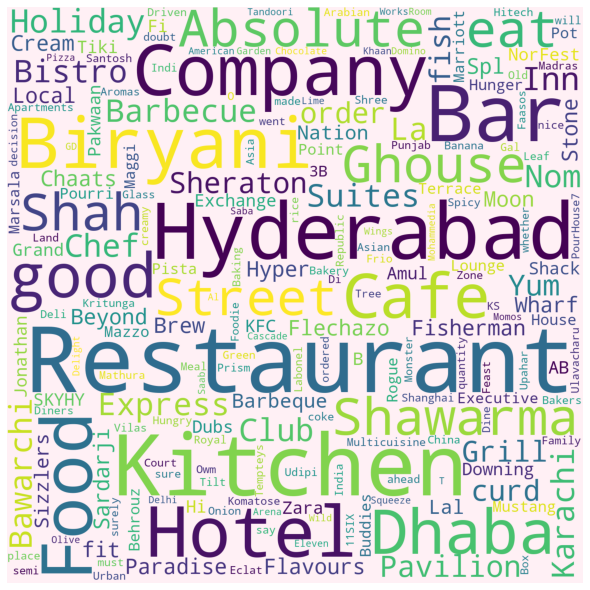

In [64]:
#To find the most common restro names 
Rests = reviews.Restaurant.unique()
rest_string = ' '
for i in Rests:
   rest_string = rest_string+i+' '
    
wordcloud = WordCloud(width = 1400, height = 1400, 
                background_color ='lavenderblush',  
                min_font_size = 12).generate(rest_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [65]:
#!pip install spacy
import spacy

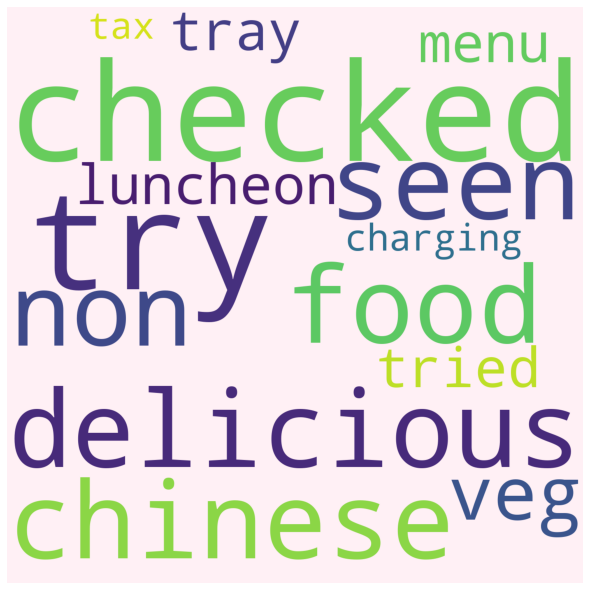

In [67]:
nlp = spacy.blank("en")#en=English, we will only consider english words
reviews_feature = reviews['Review_Clean_String']
for review in reviews_feature:
    doc = nlp(review)
words = [token.text
         for token in doc
         if not token.is_stop and not token.is_punct]
rest_string = ' '
for i in words:
   rest_string = rest_string+i+' '
    
wordcloud = WordCloud(width = 1400, height = 1400, 
                background_color ='lavenderblush',  
                min_font_size = 12).generate(rest_string) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [68]:
import itertools
import collections
Review_Clean = list(reviews["Review_Clean"])
token_list = list(itertools.chain(*Review_Clean))
counts_no = collections.Counter(token_list)
clean_reviews = pd.DataFrame(counts_no.most_common(30),columns=['words','count'])

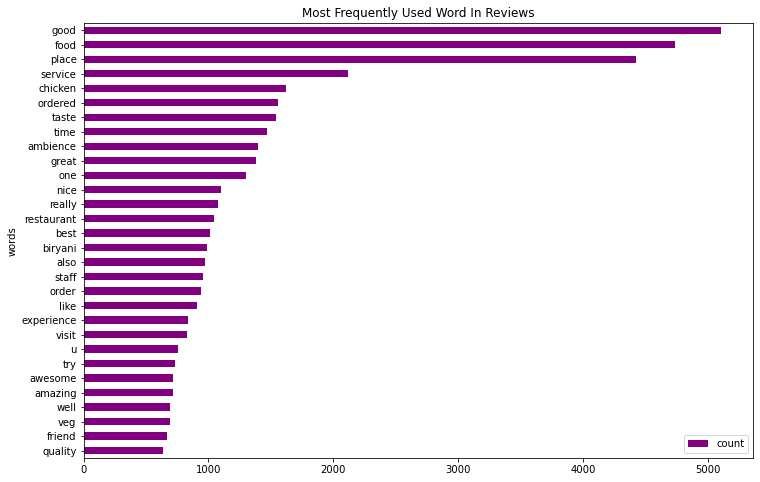

In [69]:
fig ,ax=plt.subplots(figsize=(12,8))
clean_reviews.sort_values(by='count').plot.barh(x='words',y='count',ax=ax,color="purple")
ax.set_title("Most Frequently Used Word In Reviews")
plt.show()

In [70]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
#nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

In [71]:
# Run the polarity score on the entire dataset
res = {}
for i, row in tqdm(reviews.iterrows(), total=len(reviews)):
    text = row['Review_Clean_String']
    myid = row['Restaurant']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/9956 [00:00<?, ?it/s]

In [72]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Restaurant'})
vaders = vaders.merge(reviews, how='right')

In [73]:
vaders

,Restaurant,neg,neu,pos,compound,Index,Review,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String
0,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...",ambience good food quite good saturday lunch c...
1,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...,ambience good pleasant evening service prompt ...,"[ambience, good, pleasant, evening, service, p...",ambience good pleasant evening service prompt ...
2,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...,must try great food great ambience thnx servic...,"[must, try, great, food, great, ambience, thnx...",must try great food great ambience thnx servic...
3,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...,soumen das arun great guy behavior sincerety g...,"[soumen, da, arun, great, guy, behavior, since...",soumen da arun great guy behavior sincerety go...
4,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...,food good ordered kodi drumsticks basket mutto...,"[food, good, ordered, kodi, drumstick, basket,...",food good ordered kodi drumstick basket mutton...
...,...,...,...,...,...,...,...,...,...,...,...
9951,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...,madhumathi mahajan well start nice courteous s...,"[madhumathi, mahajan, well, start, nice, court...",madhumathi mahajan well start nice courteous s...
9952,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...,place never disappointed us food courteous sta...,"[place, never, disappointed, u, food, courteou...",place never disappointed u food courteous staf...
9953,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...,bad rating mainly chicken bone found veg food ...,"[bad, rating, mainly, chicken, bone, found, ve...",bad rating mainly chicken bone found veg food ...
9954,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...,personally love prefer chinese food couple tim...,"[personally, love, prefer, chinese, food, coup...",personally love prefer chinese food couple tim...


In [74]:
def find_polarity(rev):
    return TextBlob(rev).sentiment.polarity

In [75]:
vaders["polarity"]=vaders["Review_Clean_String"].apply(find_polarity)

In [76]:
for i in range(0,len(vaders["Review"])):
            print(vaders["polarity"][i])

0.6666666666666666
0.7083333333333333
0.55
0.75
0.5599999999999999
0.7999999999999999
0.25999999999999995
0.25625
0.536734693877551
0.7514285714285714
0.58
0.5125000000000001
0.5
0.7999999999999999
-0.5
0.3666666666666667
0.7
0.3678571428571429
0.675
0.7
0.3053571428571428
0.425
0.5333333333333333
0.575
0.8
0.6551948051948051
0.6590909090909091
0.6500000000000001
0.6857954545454545
0.35
-0.1802083333333333
0.85
0.5285714285714286
0.4416666666666667
0.4909090909090909
0.39999999999999997
0.1787878787878788
1.0
0.7999999999999999
0.4333333333333333
0.36704545454545456
0.6785714285714286
0.2666666666666667
0.39999999999999997
0.7150000000000001
-0.025
0.5533333333333335
0.5
0.8333333333333333
0.5523809523809523
0.6583333333333333
0.5
0.6666666666666666
0.4310204081632654
0.5458333333333333
0.3833333333333333
0.27499999999999997
0.682
0.0
0.31666666666666665
0.59
0.8
0.625
0.375
0.58
1.0
-0.42000000000000004
0.0
0.26666666666666666
0.425
0.85
0.41904761904761906
0.56875
0.42916666666666664

0.7
0.3333333333333333
0.3
0.4261904761904762
0.08888888888888889
0.30000000000000004
0.4375
0.6388888888888888
0.2657142857142857
0.5750000000000001
0.0
0.34375
0.46
0.6
-0.2
1.0
-0.4151515151515151
0.4
0.08333333333333333
0.6666666666666666
0.04999999999999999
0.24
0.19848484848484851
0.004166666666666689
0.7999999999999999
0.7666666666666666
0.7
0.33
0.74
0.40555555555555567
0.6777777777777777
0.7666666666666666
0.55
0.16166666666666668
0.8666666666666667
0.28571428571428575
0.39999999999999997
0.5642857142857143
0.25833333333333336
0.4166666666666667
0.38
0.2833333333333333
0.6
0.6
0.17551020408163262
0.0
0.0
0.32
0.0
0.46666666666666673
0.11666666666666665
0.8
0.27777777777777773
0.41500000000000004
0.5666666666666667
0.3
1.0
0.6142857142857143
0.4583333333333333
0.4787878787878788
0.35
0.0
0.0
0.25757575757575757
0.6599999999999999
0.6000000000000001
0.35
0.3275
1.0
1.0
-0.5
0.15401785714285715
-0.16964285714285718
0.6
0.0
-0.19999999999999998
0.0
-0.037500000000000006
-0.2249999

-0.6
0.35
-0.21999999999999997
0.0
-0.06999999999999999
0.0
0.11428571428571428
-0.09999999999999999
-0.36111111111111116
0.0
0.4166666666666667
-0.6
0.7
0.5166666666666666
0.0
-0.2
0.7
0.5
0.0
0.4
-0.2
0.7
0.6
0.15
0.7
-0.06666666666666665
0.0
0.6
-0.3499999999999999
0.040624999999999994
0.35
0.3333333333333333
0.30416666666666664
-1.0
1.0
0.3
0.2
0.7
0.2
0.7
-0.028571428571428564
0.7
-0.14999999999999997
0.0
-0.23333333333333328
0.25
0.024999999999999994
1.0
0.0
0.0
-0.6
0.25
0.3333333333333333
0.8
0.0
0.7214285714285714
-1.0
-0.01333333333333333
0.0
-0.6333333333333333
-0.5958333333333333
0.7
-0.013333333333333272
0.5349999999999999
0.6
-0.10999999999999999
0.0
0.43461538461538457
0.4081632653061224
0.275
-0.48
0.272
0.03427777777777779
0.22777777777777775
0.6222222222222222
0.5833333333333334
0.08666666666666667
0.12
0.65
-0.10000000000000002
0.33647959183673465
0.42857142857142855
-0.2916666666666667
0.5
-0.09166666666666665
0.375
0.0
0.2225
0.3916666666666666
-0.10714285714285714

0.041666666666666664
0.65
0.675
0.12000000000000004
0.09869047619047619
0.42666666666666664
0.4166666666666667
0.41666666666666663
-0.3071428571428571
0.31375
0.35
0.3932900432900433
0.0
-0.3
0.7
-1.0
0.29893398268398264
0.2
0.3809523809523809
0.36851851851851847
0.5
0.7000000000000001
0.32159090909090904
0.6000000000000001
0.625
0.5083333333333333
0.5785714285714286
0.41904761904761906
0.26249999999999996
0.35
0.74
0.25079365079365085
0.525
0.8
0.0
0.2875
0.14285714285714285
0.3125
0.38571428571428573
0.22499999999999998
0.7
0.6000000000000001
0.0
0.49583333333333335
0.7333333333333334
-4.4408920985006264e-17
0.2791666666666667
0.23888888888888885
-0.505
0.6100000000000001
-1.0
0.7250000000000001
0.3333333333333333
-0.5499999999999999
-0.15
0.07047619047619047
0.43333333333333335
0.5392857142857143
0.033333333333333326
0.7
0.2979166666666667
0.3499999999999999
0.18571428571428572
0.515
-0.36666666666666664
-0.5
-0.3
0.0
-0.65
0.052000000000000005
0.26642857142857146
0.1999999999999999

0.0
-0.25937499999999997
0.24583333333333335
0.20000000000000004
0.5499999999999999
0.30714285714285716
0.31999999999999995
0.06666666666666667
0.0
0.35
0.012500000000000011
0.22656249999999997
0.2261904761904762
0.5249999999999999
0.5666666666666667
0.4444444444444444
0.37878787878787873
0.7
0.06666666666666665
0.3071428571428571
0.1880952380952381
0.5666666666666667
0.28888888888888886
0.68
0.35000000000000003
0.4166666666666667
0.4125
0.425
0.5166666666666666
0.325
0.8
0.54
0.2
0.21666666666666665
0.325
0.4166666666666667
0.6
0.5114285714285715
0.25
0.4749999999999999
0.25
0.55
0.46666666666666673
0.5375
-0.05
-0.2318181818181818
0.28888888888888886
-0.2888888888888889
0.26
0.07083333333333336
0.0
0.29333333333333333
0.14444444444444446
0.23333333333333334
0.23333333333333328
0.4958333333333333
0.027777777777777804
0.3121212121212121
-0.22499999999999998
0.32333333333333336
0.1125
0.27708333333333335
-0.055952380952380955
0.6
0.26249999999999996
0.7
0.36428571428571427
-0.0249999999

0.6
0.0
0.0
-0.8
-0.09999999999999992
0.7
0.0
0.33333333333333337
-0.39999999999999997
0.0
0.53125
-0.1277777777777778
-0.19166666666666668
-0.09166666666666665
0.031249999999999997
-0.6166666666666666
0.7
0.4392857142857143
-0.6499999999999999
-0.75
0.30000000000000004
0.0
-0.03333333333333336
0.0
-0.2
0.0
0.0
0.21296296296296297
0.5833333333333334
0.0
0.09999999999999999
-0.575
0.7
-0.05
0.7
0.43749999999999994
0.7
0.16
0.0
0.125
0.2733333333333333
0.0
0.0
-0.25
0.6
0.28750000000000003
0.7
0.7
0.42499999999999993
-0.16666666666666666
0.7
0.13333333333333333
0.2
0.6666666666666666
0.3
0.16
0.0
0.0
0.0
0.6
-1.0
0.0
-0.8
-0.11999999999999997
-0.3416666666666666
0.25952380952380955
0.42000000000000004
-0.0625
-0.27999999999999997
-1.0
0.0
0.0027777777777777866
-0.6
0.10952380952380952
0.7
0.03888888888888891
0.0
0.0
0.54
0.19999999999999998
0.35
0.48409090909090907
0.3207792207792208
0.75
0.0
0.0
0.5
0.7999999999999999
0.65
-0.125
-0.25
0.7
-0.30000000000000004
0.26666666666666666
0.0
0.

-0.6999999999999998
1.0
1.0
0.0
0.7
0.0
0.8
0.7
0.0
0.0
0.7
0.3333333333333333
0.7
0.7
0.7
0.7
-0.18611111111111112
-0.6
-1.0
-0.2
0.7
1.0
0.5
-0.6
0.075
0.0
0.6
0.23142857142857146
0.7
0.0
0.0
1.0
0.3333333333333333
-0.6999999999999998
1.0
0.24999999999999997
0.55
0.15
0.48928571428571427
0.8
0.8166666666666668
0.59375
0.5833333333333334
0.5125
1.0
0.5599999999999999
0.6000000000000001
-0.11666666666666665
0.6
0.575
0.6625000000000001
0.6196428571428572
0.7666666666666666
1.0
0.4625
1.0
0.7
0.55
0.8
0.152
0.521590909090909
0.5199999999999999
0.6999999999999998
0.6295454545454546
0.0
0.25
-0.1
0.0
0.0
0.48164335664335667
0.23611111111111108
0.15
0.2924918831168831
0.0
0.22000000000000003
0.4333333333333333
-0.21923076923076928
0.6125
0.40124458874458874
0.0
0.6000000000000001
0.11818181818181818
0.21666666666666665
0.7
-0.2
0.6142857142857143
0.875
0.21666666666666665
-0.33125
0.0
0.08333333333333333
0.25166666666666665
0.7
0.4916666666666667
-0.08299663299663297
0.14583333333333334
0.

In [77]:
vaders

,Restaurant,neg,neu,pos,compound,Index,Review,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity
0,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...",ambience good food quite good saturday lunch c...,0.666667
1,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...,ambience good pleasant evening service prompt ...,"[ambience, good, pleasant, evening, service, p...",ambience good pleasant evening service prompt ...,0.708333
2,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...,must try great food great ambience thnx servic...,"[must, try, great, food, great, ambience, thnx...",must try great food great ambience thnx servic...,0.550000
3,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...,soumen das arun great guy behavior sincerety g...,"[soumen, da, arun, great, guy, behavior, since...",soumen da arun great guy behavior sincerety go...,0.750000
4,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...,food good ordered kodi drumsticks basket mutto...,"[food, good, ordered, kodi, drumstick, basket,...",food good ordered kodi drumstick basket mutton...,0.560000
...,...,...,...,...,...,...,...,...,...,...,...,...
9951,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...,madhumathi mahajan well start nice courteous s...,"[madhumathi, mahajan, well, start, nice, court...",madhumathi mahajan well start nice courteous s...,0.402500
9952,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...,place never disappointed us food courteous sta...,"[place, never, disappointed, u, food, courteou...",place never disappointed u food courteous staf...,0.174621
9953,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...,bad rating mainly chicken bone found veg food ...,"[bad, rating, mainly, chicken, bone, found, ve...",bad rating mainly chicken bone found veg food ...,-0.650000
9954,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...,personally love prefer chinese food couple tim...,"[personally, love, prefer, chinese, food, coup...",personally love prefer chinese food couple tim...,0.250000


In [78]:
vaders["classification"] = vaders["polarity"].apply(lambda x: "Positive" if x > 0 else "Negative")

In [79]:
vaders

,Restaurant,neg,neu,pos,compound,Index,Review,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity,classification
0,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...",ambience good food quite good saturday lunch c...,0.666667,Positive
1,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...,ambience good pleasant evening service prompt ...,"[ambience, good, pleasant, evening, service, p...",ambience good pleasant evening service prompt ...,0.708333,Positive
2,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...,must try great food great ambience thnx servic...,"[must, try, great, food, great, ambience, thnx...",must try great food great ambience thnx servic...,0.550000,Positive
3,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...,soumen das arun great guy behavior sincerety g...,"[soumen, da, arun, great, guy, behavior, since...",soumen da arun great guy behavior sincerety go...,0.750000,Positive
4,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...,food good ordered kodi drumsticks basket mutto...,"[food, good, ordered, kodi, drumstick, basket,...",food good ordered kodi drumstick basket mutton...,0.560000,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9951,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...,madhumathi mahajan well start nice courteous s...,"[madhumathi, mahajan, well, start, nice, court...",madhumathi mahajan well start nice courteous s...,0.402500,Positive
9952,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...,place never disappointed us food courteous sta...,"[place, never, disappointed, u, food, courteou...",place never disappointed u food courteous staf...,0.174621,Positive
9953,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...,bad rating mainly chicken bone found veg food ...,"[bad, rating, mainly, chicken, bone, found, ve...",bad rating mainly chicken bone found veg food ...,-0.650000,Negative
9954,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...,personally love prefer chinese food couple tim...,"[personally, love, prefer, chinese, food, coup...",personally love prefer chinese food couple tim...,0.250000,Positive


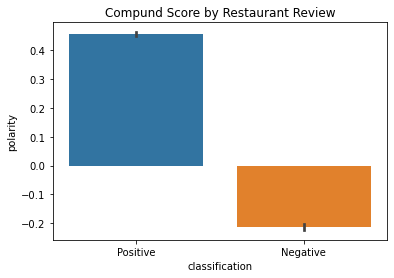

In [80]:
ax = sns.barplot(data=vaders, x='classification', y='polarity')
ax.set_title('Compund Score by Restaurant Review')
plt.show()

<AxesSubplot:xlabel='classification', ylabel='count'>

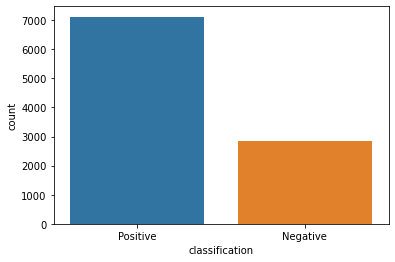

In [81]:
sns.countplot(x="classification",data=vaders)

<AxesSubplot:xlabel='polarity', ylabel='Count'>

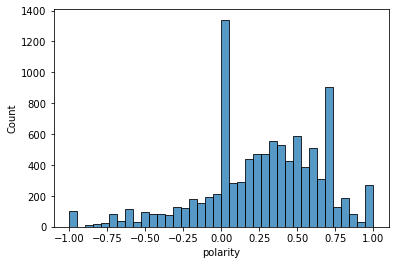

In [82]:
sns.histplot(vaders['polarity'])

In [83]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [84]:
tfidf_converter = TfidfVectorizer(max_features=2000)
features = tfidf_converter.fit_transform(vaders['Review_Clean_String']).toarray()

In [85]:
!pip install lightgbm
!pip install scikit-learn

In [86]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
target = vaders['classification']
x_train , x_test ,y_train ,y_test = train_test_split(features,target,test_size=0.3)
clf = lgb.LGBMClassifier(max_depth=20,
                        n_estimators=25,
                        min_child_weights=0.0016,
                        n_jobs=-1)
clf.fit(x_train,y_train)
pred = clf.predict(x_test)
print("Test data Accuracy is:",accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

[LightGBM] [Warning] Unknown parameter: min_child_weights
Test data Accuracy is: 0.9163039839303649
              precision    recall  f1-score   support

    Negative       0.85      0.87      0.86       876
    Positive       0.94      0.94      0.94      2111

    accuracy                           0.92      2987
   macro avg       0.90      0.90      0.90      2987
weighted avg       0.92      0.92      0.92      2987



<AxesSubplot:>

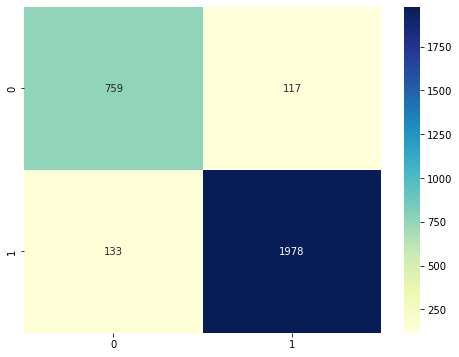

In [87]:
cm = confusion_matrix(y_test,pred)

fig,ax= plt.subplots(figsize=(8,6))
sns.heatmap(cm,annot=True ,fmt ='d',cmap = 'YlGnBu')

In [88]:
vaders["nb_words"] = vaders["Review_Clean_String"].apply(lambda x: len(x.split(" ")))

In [89]:
vaders

,Restaurant,neg,neu,pos,compound,Index,Review,corpus_series,corpus_series_without_stopwords,Review_Clean,Review_Clean_String,polarity,classification,nb_words
0,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,The ambience was good. food was quite good . h...,the ambience was good food was quite good had ...,ambience good food quite good saturday lunch c...,"[ambience, good, food, quite, good, saturday, ...",ambience good food quite good saturday lunch c...,0.666667,Positive,9
1,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Ambience is too good for a pleasant evening. S...,ambience is too good for a pleasant evening se...,ambience good pleasant evening service prompt ...,"[ambience, good, pleasant, evening, service, p...",ambience good pleasant evening service prompt ...,0.708333,Positive,14
2,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,A must try.. great food great ambience. Thnx f...,a must try great food great ambience thnx for ...,must try great food great ambience thnx servic...,"[must, try, great, food, great, ambience, thnx...",must try great food great ambience thnx servic...,0.550000,Positive,19
3,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Soumen das and Arun was a great guy. Only beca...,soumen das and arun was a great guy only becau...,soumen das arun great guy behavior sincerety g...,"[soumen, da, arun, great, guy, behavior, since...",soumen da arun great guy behavior sincerety go...,0.750000,Positive,14
4,Beyond Flavours,0.0,0.661,0.339,0.8271,11.0,Food is good.we ordered Kodi drumsticks and ba...,food is good we ordered kodi drumsticks and ba...,food good ordered kodi drumsticks basket mutto...,"[food, good, ordered, kodi, drumstick, basket,...",food good ordered kodi drumstick basket mutton...,0.560000,Positive,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9951,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,Madhumathi Mahajan Well to start with nice cou...,madhumathi mahajan well to start with nice cou...,madhumathi mahajan well start nice courteous s...,"[madhumathi, mahajan, well, start, nice, court...",madhumathi mahajan well start nice courteous s...,0.402500,Positive,31
9952,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,This place has never disappointed us.. The foo...,this place has never disappointed us the food ...,place never disappointed us food courteous sta...,"[place, never, disappointed, u, food, courteou...",place never disappointed u food courteous staf...,0.174621,Positive,32
9953,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,"""Bad rating is mainly because of """"Chicken Bon...",bad rating is mainly because of chicken bone f...,bad rating mainly chicken bone found veg food ...,"[bad, rating, mainly, chicken, bone, found, ve...",bad rating mainly chicken bone found veg food ...,-0.650000,Negative,10
9954,Chinese Pavilion,0.0,0.791,0.209,0.5719,15.0,I personally love and prefer Chinese Food. Had...,i personally love and prefer chinese food had ...,personally love prefer chinese food couple tim...,"[personally, love, prefer, chinese, food, coup...",personally love prefer chinese food couple tim...,0.250000,Positive,8


In [90]:
vaders[vaders["nb_words"]>= 5].sort_values("polarity", ascending = False)[["Review_Clean_String","classification","Restaurant"]].head(100)

,Review_Clean_String,classification,Restaurant
3352,place awesome compare nearby restaurant gachib...,Positive,Club Rogue
8990,one best place chill friend people visit place...,Positive,Arena Eleven
3199,went place weekday also found place crowd perf...,Positive,Marsala Food Company
2200,best place want see sport screening,Positive,B-Dubs
754,one best shawarma joint hyderabad,Positive,Shah Ghouse Spl Shawarma
...,...,...,...
2418,dj floor best part skyhy,Positive,SKYHY
37,food ordered banjara tangdi starter best among...,Positive,Beyond Flavours
7207,best brownie cupcake town chocolatey feel get ...,Positive,Labonel
4821,best coconut chutney sambhar town pick food it...,Positive,Udipi's Upahar


In [91]:
vaders[vaders["nb_words"] >= 5].sort_values("polarity", ascending = True)[["Review_Clean_String","classification","Restaurant"]].head(10)

,Review_Clean_String,classification,Restaurant
7754,horrible food noodle called starter basically ...,Negative,Squeeze @ The Lime
826,horrible food variety wanted give zero star,Negative,Hyper Local
8192,please refund order amount food pathetic today,Negative,Delhi-39
2150,worst dining experience ever till,Negative,Jonathan's Kitchen - Holiday Inn Express & Suites
7540,never try ulvacharu biryani worst ever,Negative,Royal Spicy Restaurant
4512,time time worst experience waiter othe worls a...,Negative,Owm Nom Nom
2882,order deliver food cancelled without notifying...,Negative,Behrouz Biryani
5371,visited place team lunch experience pathetic,Negative,Diners Pavilion
2875,ordered biriyani restaurant took close one hou...,Negative,Behrouz Biryani
4412,pathetic customer service called enquired stag...,Negative,La La Land - Bar & Kitchen


### Df2

In [92]:
client = MongoClient('localhost',27017)
db = client.Rest
data = db.dataset_2
df2 = pd.DataFrame(list(data.find()))
df2

,_id,Restaurant,Reviewer,Rating,Rating_index,Restaurant_index,Reviewer_index
0,63254bd2fa714c70be069c35,Beyond Flavours,Rusha Chakraborty,5,0.0,14.0,5430.0
1,63254bd2fa714c70be069c36,Beyond Flavours,Anusha Tirumalaneedi,5,0.0,14.0,1953.0
2,63254bd2fa714c70be069c37,Beyond Flavours,Ashok Shekhawat,5,0.0,14.0,2102.0
3,63254bd2fa714c70be069c38,Beyond Flavours,Swapnil Sarkar,5,0.0,14.0,6759.0
4,63254bd2fa714c70be069c39,Beyond Flavours,Dileep,5,0.0,14.0,354.0
...,...,...,...,...,...,...,...
9957,63254bd2fa714c70be06c31a,Chinese Pavilion,Abhishek Mahajan,3,3.0,18.0,540.0
9958,63254bd2fa714c70be06c31b,Chinese Pavilion,Sharad Agrawal,4.5,5.0,18.0,5977.0
9959,63254bd2fa714c70be06c31c,Chinese Pavilion,Ramandeep,1.5,8.0,18.0,5127.0
9960,63254bd2fa714c70be06c31d,Chinese Pavilion,Nayana Shanbhag,4,1.0,18.0,4297.0


In [93]:
df2.isnull().sum()

_id                 0
Restaurant          0
Reviewer            0
Rating              0
Rating_index        0
Restaurant_index    0
Reviewer_index      0
dtype: int64

In [94]:
df = df2.copy()#making a copy of the df

In [95]:
df

,_id,Restaurant,Reviewer,Rating,Rating_index,Restaurant_index,Reviewer_index
0,63254bd2fa714c70be069c35,Beyond Flavours,Rusha Chakraborty,5,0.0,14.0,5430.0
1,63254bd2fa714c70be069c36,Beyond Flavours,Anusha Tirumalaneedi,5,0.0,14.0,1953.0
2,63254bd2fa714c70be069c37,Beyond Flavours,Ashok Shekhawat,5,0.0,14.0,2102.0
3,63254bd2fa714c70be069c38,Beyond Flavours,Swapnil Sarkar,5,0.0,14.0,6759.0
4,63254bd2fa714c70be069c39,Beyond Flavours,Dileep,5,0.0,14.0,354.0
...,...,...,...,...,...,...,...
9957,63254bd2fa714c70be06c31a,Chinese Pavilion,Abhishek Mahajan,3,3.0,18.0,540.0
9958,63254bd2fa714c70be06c31b,Chinese Pavilion,Sharad Agrawal,4.5,5.0,18.0,5977.0
9959,63254bd2fa714c70be06c31c,Chinese Pavilion,Ramandeep,1.5,8.0,18.0,5127.0
9960,63254bd2fa714c70be06c31d,Chinese Pavilion,Nayana Shanbhag,4,1.0,18.0,4297.0


In [96]:
y = df["Rating"] #  taking Rating as a dependent variable
X = df.drop(columns=["Restaurant","_id","Reviewer","Rating","Rating_index"])# taking  Review as a independent variable
X.shape

(9962, 2)

In [97]:
X

,Restaurant_index,Reviewer_index
0,14.0,5430.0
1,14.0,1953.0
2,14.0,2102.0
3,14.0,6759.0
4,14.0,354.0
...,...,...
9957,18.0,540.0
9958,18.0,5977.0
9959,18.0,5127.0
9960,18.0,4297.0


In [98]:
y.shape

(9962,)

In [99]:
y


0         5
1         5
2         5
3         5
4         5
       ... 
9957      3
9958    4.5
9959    1.5
9960      4
9961    3.5
Name: Rating, Length: 9962, dtype: object

In [100]:
y=y.replace(to_replace="Like",value=3)
y

0         5
1         5
2         5
3         5
4         5
       ... 
9957      3
9958    4.5
9959    1.5
9960      4
9961    3.5
Name: Rating, Length: 9962, dtype: object

In [101]:
y=y.replace(to_replace="12/1/2018  9:01:00 AM",value=0)

In [102]:
y=y.astype(float)

In [103]:
for i in range(0,len(y)):
    if (y[i] >= 3):
        y[i] = "Positive"
    else:
        y[i] = "Negative"

In [104]:
y

0       Positive
1       Positive
2       Positive
3       Positive
4       Positive
          ...   
9957    Positive
9958    Positive
9959    Negative
9960    Positive
9961    Positive
Name: Rating, Length: 9962, dtype: object

In [105]:
y.unique()

array(['Positive', 'Negative'], dtype=object)

## Logistic Regression

In [106]:
# importing all libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

In [107]:
# Train  Test  split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                    random_state=2022,
                                                    stratify=y)

In [108]:
X_train

,Restaurant_index,Reviewer_index
8604,80.0,64.0
9450,29.0,6087.0
3177,66.0,706.0
2134,44.0,5420.0
7979,61.0,5882.0
...,...,...
3074,67.0,4168.0
8079,78.0,1845.0
3957,23.0,206.0
5903,46.0,6939.0


In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



In [110]:
# Building model
model = LogisticRegression(solver='sag',max_iter=10000,multi_class='ovr')

In [111]:
model.fit(X_train,y_train)

LogisticRegression(max_iter=10000, multi_class='ovr', solver='sag')

In [112]:
print(model.intercept_)

[1.13139966]


In [113]:
print(model.coef_)

[[ 0.01210927 -0.2011618 ]]


In [114]:
# Prdecting model
y_pred_prob = model.predict_proba(X_test)[:,1]
print(roc_auc_score(y_test, y_pred_prob))


0.5969178392551823


## Random Forest

In [115]:
from sklearn.ensemble import RandomForestClassifier
randomclassifier=RandomForestClassifier(n_estimators=200,criterion='entropy')
randomclassifier.fit(X_train,y_train)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [116]:
RandomForestClassifier(criterion='entropy', n_estimators=200)

RandomForestClassifier(criterion='entropy', n_estimators=200)

In [117]:
y_pred = randomclassifier.predict(X_test)

In [118]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[ 197  537]
 [ 366 1889]]


In [119]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6978922716627635


## SVM

In [120]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [121]:
y_pred = clf.predict(X_test)

In [122]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[   0  734]
 [   0 2255]]


In [123]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.7544329207092673


## KNN

In [124]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 3, metric = 'minkowski', p = 2) 
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [125]:
from sklearn.metrics import confusion_matrix
confusion_m = confusion_matrix(y_test, y_pred)
print(confusion_m)

[[ 161  573]
 [ 324 1931]]


In [126]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6998996319839411


In [127]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [128]:
from sklearn.decomposition import PCA
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

C:\Users\jarvi\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



Text(0.5, 1.0, 'Count of ratings given')

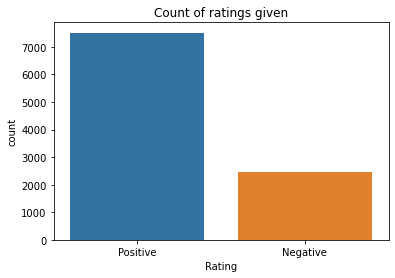

In [129]:
eda =y
sns.countplot(eda)
plt.title('Count of ratings given')

<AxesSubplot:title={'center':'Users with the most reviews '}>

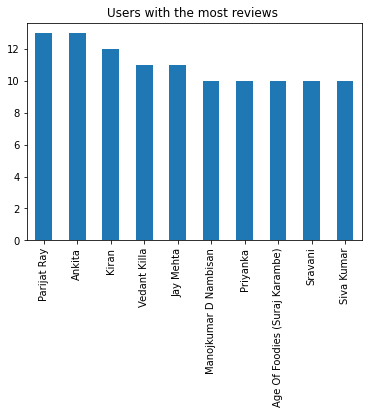

In [130]:
df['Reviewer'].value_counts().head(10).plot.bar( title='Users with the most reviews ')

<AxesSubplot:title={'center':'Restaurant with most reviews'}>

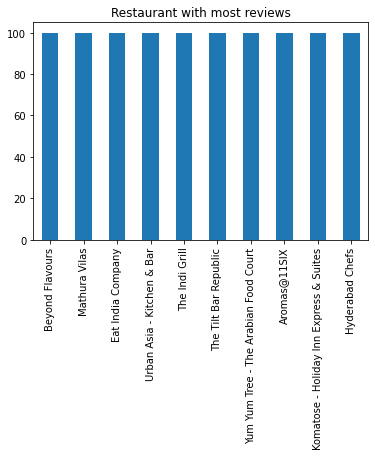

In [131]:
df['Restaurant'].value_counts().head(10).plot.bar(title='Restaurant with most reviews')

## Collaborative Filtering & UI

In [132]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns

In [133]:
df['Restaurant_index'] = df['Restaurant_index'].astype(int)
df['Reviewer_index'] = df['Reviewer_index'].astype(int)
df['Rating_index'] = df['Rating_index'].astype(int)


In [134]:
df['Rating_index'].dtype

dtype('int32')

In [135]:
df['Reviewer_index'].max()


7446

In [136]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000, stop_words='english')

In [137]:
vectors = cv.fit_transform(vaders['Review_Clean_String']).toarray()
vectors

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [138]:
cv.get_feature_names()

C:\Users\jarvi\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['aa',
 'aaloo',
 'aalu',
 'ab',
 'aback',
 'abdul',
 'abhay',
 'abhinav',
 'abhishek',
 'able',
 'abruptly',
 'absolute',
 'absolutely',
 'abt',
 'ac',
 'accept',
 'acceptable',
 'accepted',
 'accepting',
 'accepts',
 'access',
 'accessible',
 'accommodate',
 'accommodated',
 'accommodating',
 'accompanied',
 'accompaniment',
 'according',
 'accordingly',
 'account',
 'achari',
 'ache',
 'act',
 'action',
 'active',
 'activity',
 'actual',
 'actually',
 'add',
 'added',
 'addict',
 'addicted',
 'adding',
 'addition',
 'additional',
 'additionally',
 'address',
 'adequate',
 'adil',
 'adjacent',
 'admin',
 'administration',
 'admit',
 'admitted',
 'adraki',
 'adult',
 'advance',
 'advantage',
 'advertisement',
 'advice',
 'advise',
 'aesthetic',
 'af',
 'affect',
 'affected',
 'afford',
 'affordable',
 'afgani',
 'afghan',
 'afghani',
 'afternoon',
 'aftr',
 'age',
 'agen',
 'agent',
 'aglio',
 'ago',
 'agree',
 'agreed',
 'ah',
 'ahead',
 'ahmed',
 'air',
 'airport',
 'ajay',
 'akash'

In [314]:
#!pip install sklearn

ERROR: Could not find a version that satisfies the requirement sklearn.metric (from versions: none)
ERROR: No matching distribution found for sklearn.metric


In [139]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(vectors)

In [140]:
def recommend(restaurant_name):
    restaurant_index = df[df['Restaurant'] == restaurant_name].index[0]
    distances = similarity[restaurant_index]
    r_list=sorted(list(enumerate(distances)),reverse= True,key=lambda x:x[1])[1:6]
    
    for i in r_list:
        print(df.iloc[i[0]].Restaurant)

In [141]:
recommend('Beyond Flavours')

PourHouse7
The Lal Street - Bar Exchange
10 Downing Street
Olive Garden
Flechazo


In [142]:
import pickle

In [143]:
df=df.drop(columns=['_id'],axis=1)


In [331]:
#pickle.dump(df.to_dict(),open('restaurant_review_dict.pkl','wb'))

In [332]:
#pickle.dump(similarity,open('similarity.pkl','wb'))